<a href="https://colab.research.google.com/github/PoliNemkova/crypto/blob/master/Correlation_Random_Forest_ARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data collection

In [ ]:
# Pandas is used for data manipulation
import pandas as pd
# Read in data and display first 5 rows
features = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')
features.head(5)

,date,sum_new_cases,kurt_new_cases,skew_new_cases,mean_new_cases,sum_cumulative_cases,kurt_cumulative_cases,skew_cumulative_cases,mean_cumulative_cases,sum_new_deaths,kurt_new_deaths,skew_new_deaths,mean_new_deaths,sum_cumulative_deaths,kurt_cumulative_deaths,skew_cumulative_deaths,mean_cumulative_deaths,sum_open,kurt_open,skew_open,mean_open,sum_close,kurt_close,skew_close,mean_close,sum_high,kurt_high,skew_high,mean_high,sum_low,kurt_low,skew_low,mean_low,sum_volume,kurt_volume,skew_volume,mean_volume
0,2020-01-04,1,NaN,NaN,1.0,1,NaN,NaN,1.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.155771e+07,0.451658,1.233273,8026.185221,1.155732e+07,0.466672,1.237289,8025.913318,1.156170e+07,0.433925,1.228430,8028.955982,1.155310e+07,0.483419,1.239813,8022.987117,9277.814487,39.503250,5.532453,6.442927
1,2020-01-05,0,NaN,NaN,0.0,1,NaN,NaN,1.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.125633e+07,-0.274068,0.351701,7816.897796,1.125624e+07,-0.263122,0.355732,7816.835135,1.125929e+07,-0.239182,0.371653,7818.948853,1.125331e+07,-0.297858,0.337441,7814.797290,5054.642417,130.693513,9.044665,3.510168
2,2020-01-06,3,NaN,NaN,3.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.160109e+07,0.152617,-0.361131,8061.907943,1.160120e+07,0.145170,-0.353283,8061.987280,1.160525e+07,0.166345,-0.345549,8064.805258,1.159688e+07,0.119876,-0.365475,8058.987007,7423.894835,48.902356,5.873110,5.159065
3,2020-01-07,0,NaN,NaN,0.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.165830e+07,0.213580,0.026381,8096.039051,1.165836e+07,0.217877,0.023925,8096.081200,1.166053e+07,0.414974,0.143030,8097.590995,1.165605e+07,0.146655,-0.096457,8094.479811,3561.372111,80.973427,7.731762,2.473175
4,2020-01-08,0,NaN,NaN,0.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.168059e+07,-0.687115,0.160342,8111.518408,1.168053e+07,-0.687106,0.160706,8111.475775,1.168213e+07,-0.640469,0.196860,8112.589977,1.167902e+07,-0.709490,0.132602,8110.431047,3266.132200,97.576419,7.478812,2.268147


In [ ]:
#Adding new feature mean_price
features['mean_price']=(features['mean_high']+features['mean_low'])/2

In [ ]:
features=features.fillna(0)


In [ ]:
features.head(5)

,date,sum_new_cases,kurt_new_cases,skew_new_cases,mean_new_cases,sum_cumulative_cases,kurt_cumulative_cases,skew_cumulative_cases,mean_cumulative_cases,sum_new_deaths,kurt_new_deaths,skew_new_deaths,mean_new_deaths,sum_cumulative_deaths,kurt_cumulative_deaths,skew_cumulative_deaths,mean_cumulative_deaths,sum_open,kurt_open,skew_open,mean_open,sum_close,kurt_close,skew_close,mean_close,sum_high,kurt_high,skew_high,mean_high,sum_low,kurt_low,skew_low,mean_low,sum_volume,kurt_volume,skew_volume,mean_volume,mean_price
0,2020-01-04,1,0.0,0.0,1.0,1,0.0,0.0,1.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.155771e+07,0.451658,1.233273,8026.185221,1.155732e+07,0.466672,1.237289,8025.913318,1.156170e+07,0.433925,1.228430,8028.955982,1.155310e+07,0.483419,1.239813,8022.987117,9277.814487,39.503250,5.532453,6.442927,8025.971550
1,2020-01-05,0,0.0,0.0,0.0,1,0.0,0.0,1.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.125633e+07,-0.274068,0.351701,7816.897796,1.125624e+07,-0.263122,0.355732,7816.835135,1.125929e+07,-0.239182,0.371653,7818.948853,1.125331e+07,-0.297858,0.337441,7814.797290,5054.642417,130.693513,9.044665,3.510168,7816.873071
2,2020-01-06,3,0.0,0.0,3.0,4,0.0,0.0,4.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.160109e+07,0.152617,-0.361131,8061.907943,1.160120e+07,0.145170,-0.353283,8061.987280,1.160525e+07,0.166345,-0.345549,8064.805258,1.159688e+07,0.119876,-0.365475,8058.987007,7423.894835,48.902356,5.873110,5.159065,8061.896132
3,2020-01-07,0,0.0,0.0,0.0,4,0.0,0.0,4.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.165830e+07,0.213580,0.026381,8096.039051,1.165836e+07,0.217877,0.023925,8096.081200,1.166053e+07,0.414974,0.143030,8097.590995,1.165605e+07,0.146655,-0.096457,8094.479811,3561.372111,80.973427,7.731762,2.473175,8096.035403
4,2020-01-08,0,0.0,0.0,0.0,4,0.0,0.0,4.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.168059e+07,-0.687115,0.160342,8111.518408,1.168053e+07,-0.687106,0.160706,8111.475775,1.168213e+07,-0.640469,0.196860,8112.589977,1.167902e+07,-0.709490,0.132602,8110.431047,3266.132200,97.576419,7.478812,2.268147,8111.510512


#Random Forest

In [ ]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(features['mean_high'])
# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('mean_high', axis = 1)
features= features.drop('date', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

#train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# print('Validating Features Shape:', val_features.shape)
# print('Validating Labels Shape:', val_labels.shape)

Training Features Shape: (196, 36)
Training Labels Shape: (196,)
Testing Features Shape: (50, 36)
Testing Labels Shape: (50,)


In [ ]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('mean_close')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  2.55


In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 36.48 degrees.


In [ ]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 99.5 %.


In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')


In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sum_close            Importance: 0.13
Variable: sum_low              Importance: 0.13
Variable: mean_low             Importance: 0.13
Variable: mean_price           Importance: 0.13
Variable: sum_open             Importance: 0.12
Variable: mean_open            Importance: 0.12
Variable: mean_close           Importance: 0.12
Variable: sum_high             Importance: 0.12
Variable: sum_new_cases        Importance: 0.0
Variable: kurt_new_cases       Importance: 0.0
Variable: skew_new_cases       Importance: 0.0
Variable: mean_new_cases       Importance: 0.0
Variable: sum_cumulative_cases Importance: 0.0
Variable: kurt_cumulative_cases Importance: 0.0
Variable: skew_cumulative_cases Importance: 0.0
Variable: mean_cumulative_cases Importance: 0.0
Variable: sum_new_deaths       Importance: 0.0
Variable: kurt_new_deaths      Importance: 0.0
Variable: skew_new_deaths      Importance: 0.0
Variable: mean_new_deaths      Importance: 0.0
Variable: sum_cumulative_deaths Importance: 0.0
V

In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('mean_close'), feature_list.index('sum_low')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 22.63 degrees.
Accuracy: 99.7 %.


In [ ]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_indices = [feature_list.index('mean_close'), feature_list.index('sum_low')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels)
# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 22.63 degrees.
Accuracy: 99.7 %.


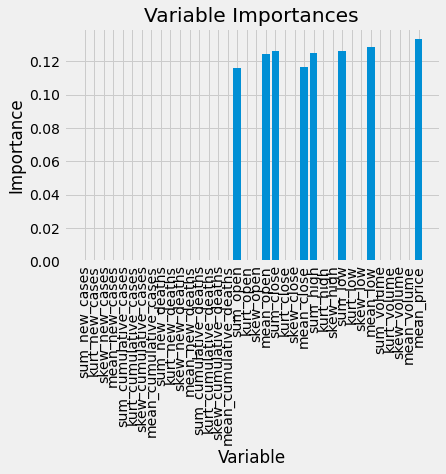

In [ ]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,9))
plt.plot(range(features.shape[0]),(features['mean_high']+features['mean_low'])/2.0)
#plt.xticks(range(0,features.shape[0],246),features['date'].loc[::246],rotation=45)
plt.xlabel('date',fontsize=18)
plt.ylabel('Mean Price',fontsize=18)
plt.show()

IndexError: ignored

<Figure size 1296x648 with 0 Axes>

In [ ]:
print('The shape of our features is:', features.shape)

In [ ]:
features = features.fillna(0)

In [ ]:
# Descriptive statistics for each column
features.describe()

# Correlation


In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')


In [ ]:
#Adding new feature mean_price
data['mean_price']=(data['mean_high']+data['mean_low'])/2

In [ ]:
data.head(5)

,date,sum_new_cases,kurt_new_cases,skew_new_cases,mean_new_cases,sum_cumulative_cases,kurt_cumulative_cases,skew_cumulative_cases,mean_cumulative_cases,sum_new_deaths,kurt_new_deaths,skew_new_deaths,mean_new_deaths,sum_cumulative_deaths,kurt_cumulative_deaths,skew_cumulative_deaths,mean_cumulative_deaths,sum_open,kurt_open,skew_open,mean_open,sum_close,kurt_close,skew_close,mean_close,sum_high,kurt_high,skew_high,mean_high,sum_low,kurt_low,skew_low,mean_low,sum_volume,kurt_volume,skew_volume,mean_volume,mean_price
0,2020-01-04,1,NaN,NaN,1.0,1,NaN,NaN,1.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.155771e+07,0.451658,1.233273,8026.185221,1.155732e+07,0.466672,1.237289,8025.913318,1.156170e+07,0.433925,1.228430,8028.955982,1.155310e+07,0.483419,1.239813,8022.987117,9277.814487,39.503250,5.532453,6.442927,8025.971550
1,2020-01-05,0,NaN,NaN,0.0,1,NaN,NaN,1.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.125633e+07,-0.274068,0.351701,7816.897796,1.125624e+07,-0.263122,0.355732,7816.835135,1.125929e+07,-0.239182,0.371653,7818.948853,1.125331e+07,-0.297858,0.337441,7814.797290,5054.642417,130.693513,9.044665,3.510168,7816.873071
2,2020-01-06,3,NaN,NaN,3.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.160109e+07,0.152617,-0.361131,8061.907943,1.160120e+07,0.145170,-0.353283,8061.987280,1.160525e+07,0.166345,-0.345549,8064.805258,1.159688e+07,0.119876,-0.365475,8058.987007,7423.894835,48.902356,5.873110,5.159065,8061.896132
3,2020-01-07,0,NaN,NaN,0.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.165830e+07,0.213580,0.026381,8096.039051,1.165836e+07,0.217877,0.023925,8096.081200,1.166053e+07,0.414974,0.143030,8097.590995,1.165605e+07,0.146655,-0.096457,8094.479811,3561.372111,80.973427,7.731762,2.473175,8096.035403
4,2020-01-08,0,NaN,NaN,0.0,4,NaN,NaN,4.0,0,NaN,NaN,0.0,0,NaN,NaN,0.0,1.168059e+07,-0.687115,0.160342,8111.518408,1.168053e+07,-0.687106,0.160706,8111.475775,1.168213e+07,-0.640469,0.196860,8112.589977,1.167902e+07,-0.709490,0.132602,8110.431047,3266.132200,97.576419,7.478812,2.268147,8111.510512


In [ ]:
cor_matrix = data.corr() #Pearson correlation
print(cor_matrix)
cor_matrix.to_csv('cor_matrix.csv')


                        sum_new_cases  kurt_new_cases  ...  skew_volume  mean_volume
sum_new_cases                1.000000        0.253893  ...     0.182279    -0.267833
kurt_new_cases               0.253893        1.000000  ...    -0.065722    -0.008150
skew_new_cases               0.412509        0.979993  ...    -0.100977    -0.003087
mean_new_cases               0.995967        0.225060  ...     0.181229    -0.271147
sum_cumulative_cases         0.945390        0.119080  ...     0.150748    -0.245455
kurt_cumulative_cases        0.297484        0.584903  ...     0.036998     0.050125
skew_cumulative_cases        0.391347        0.578238  ...    -0.052762     0.095647
mean_cumulative_cases        0.943687        0.112891  ...     0.150219    -0.245234
sum_new_deaths               0.760295        0.681252  ...     0.110201    -0.204965
kurt_new_deaths              0.077726        0.593002  ...    -0.016526     0.043457
skew_new_deaths              0.210127        0.558508  ...    -0.

In [ ]:
cor_matrix_kendall = data.corr(method = 'kendall') #Kendall correlation
cor_matrix.to_csv('cor_matrix_kendall.csv')


In [ ]:
cor_matrix_spearman = data.corr(method = 'spearman') #Spearman correlation
cor_matrix.to_csv('cor_matrix_spearman.csv')

In [ ]:
#checking p-values
from scipy.stats import pearsonr
print(pearsonr(data['mean_price'], data['sum_cumulative_deaths']))
print(pearsonr(data['mean_high'], data['mean_cumulative_deaths']))
print(pearsonr(data['mean_high'], data['sum_cumulative_cases']))
print(pearsonr(data['mean_high'], data['mean_cumulative_cases']))
print(pearsonr(data['mean_high'], data['sum_new_deaths']))
print(pearsonr(data['mean_high'], data['sum_new_cases']))
print(pearsonr(data['mean_volume'], data['sum_cumulative_deaths']))


(0.7094713947824005, 5.933763815063741e-39)
(0.7113680980564646, 3.0472371527460676e-39)
(0.7073259172709309, 1.2529104049871696e-38)
(0.7103448124829108, 4.3686041898316085e-39)
(0.31777494841915427, 3.55614246482189e-07)
(0.6515752321226791, 4.096141441078279e-31)
(-0.2756690296932743, 1.1493579366350242e-05)


**Different way of calculationg correlation (with p-values!)**

In [ ]:
data=data.drop(['date'], axis=1)

In [ ]:
data=data.astype(float)

In [ ]:
 data1=data.values

In [ ]:
data1.shape

(246, 37)

In [ ]:
corr_matrix, p_matrix = scipy.stats.spearmanr(data1, axis=0)


In [ ]:
corr_matrix
np.savetxt("corr_matrix.csv", corr_matrix, delimiter=",")

In [ ]:
corr_matrix.shape

(37, 37)

In [ ]:
p_matrix
np.savetxt("p_matrix.csv", p_matrix, delimiter=",")

In [ ]:
p_matrix.shape

(37, 37)

#ARIMAX (with Covid-19)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')

In [ ]:
#Adding new feature mean_price
data['mean_price']=(data['mean_high']+data['mean_low'])/2

In [ ]:
data=data.drop(['date','skew_volume','kurt_volume','skew_low','kurt_low','kurt_high', 'skew_high', 'kurt_close',
       'skew_close','kurt_open', 'skew_open','kurt_cumulative_deaths',
       'skew_cumulative_deaths', 'kurt_new_deaths', 'skew_new_deaths',  'kurt_cumulative_cases',
       'skew_cumulative_cases', 'kurt_new_cases', 'skew_new_cases'], axis=1)

In [ ]:
!pip install numdifftools
!pip install pyflux

     |████████████████████████████████| 962kB 2.5MB/s 
     |████████████████████████████████| 1.3MB 2.5MB/s 
  Created wheel for pyflux: filename=pyflux-0.4.15-cp36-cp36m-linux_x86_64.whl size=4656606 sha256=50753ac8cd63ab2c61238c21b4e26aeddcb131f81899d70b5c6f1231af5230ab
  Stored in directory: /root/.cache/pip/wheels/36/24/09/d18fa4f926cc90598d23ebd09fb4b0fd7b3dd1d2f506b952de
Successfully built pyflux


In [ ]:
import patsy
import seaborn
import scipy
import numdifftools
import matplotlib
import pyflux as pf

In [ ]:
data.shape

(246, 19)

In [ ]:
#ARIMAX model: regression of mean_price 
model = pf.ARIMAX(data=data, formula= 'mean_price ~ sum_cumulative_cases + mean_cumulative_cases+mean_new_cases+sum_cumulative_cases+sum_cumulative_deaths+mean_cumulative_deaths',
                  ar=1, ma=1, family=pf.Normal)
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: mean_price                          Method: MLE                                       
Start Date: 1                                           Log Likelihood: -2054.7219                        
End Date: 245                                           AIC: 4127.4438                                    
Number of observations: 245                             BIC: 4158.9551                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    1.0322     0.0501     20.6039  0.0      (0.934 | 1.1304)         
MA(1)                                

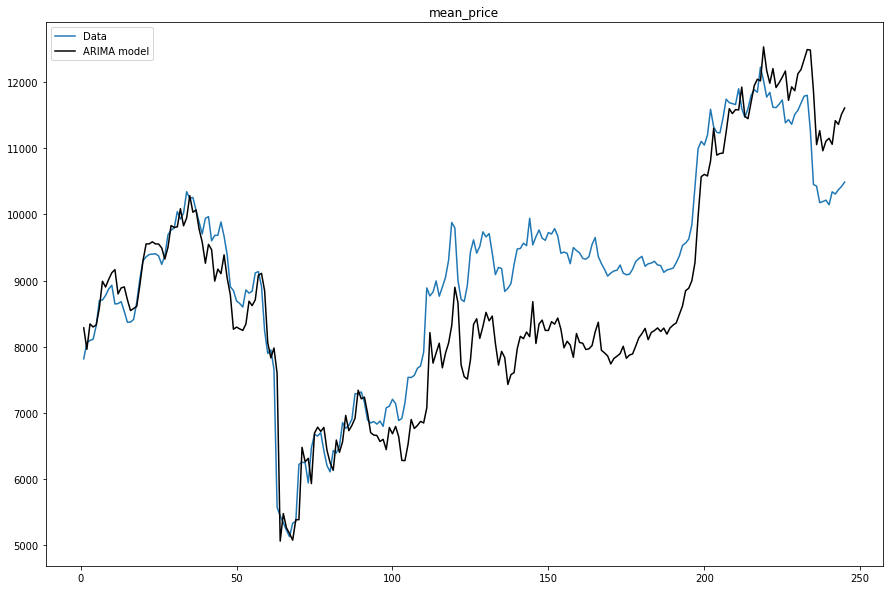

In [ ]:
#ARIMAX model: regression of mean_price
model.plot_fit(figsize=(15,10))

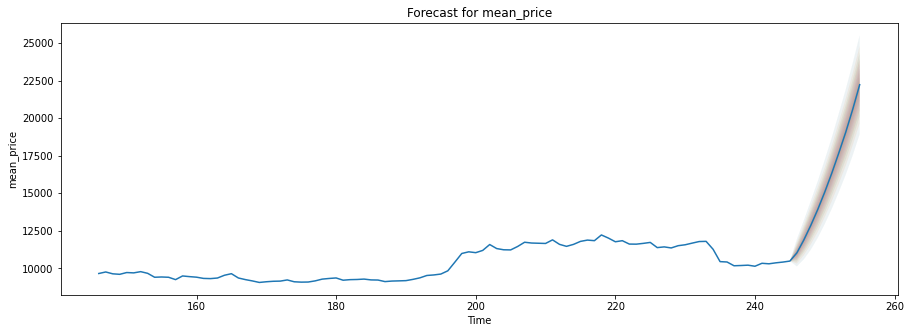

In [ ]:
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))

In [ ]:
#ARIMAX model: regression of mean_low 
model = pf.ARIMAX(data=data, formula= 'mean_low ~ sum_cumulative_cases + mean_cumulative_cases+sum_cumulative_deaths+mean_cumulative_deaths',
                  ar=1, ma=1, family=pf.Normal)
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: mean_low                            Method: MLE                                       
Start Date: 1                                           Log Likelihood: -1426636.7797                     
End Date: 245                                           AIC: 2853289.5593                                 
Number of observations: 245                             BIC: 2853317.5694                                 
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.9935     0.0002     4046.930 0.0      (0.993 | 0.994)          
MA(1)                                

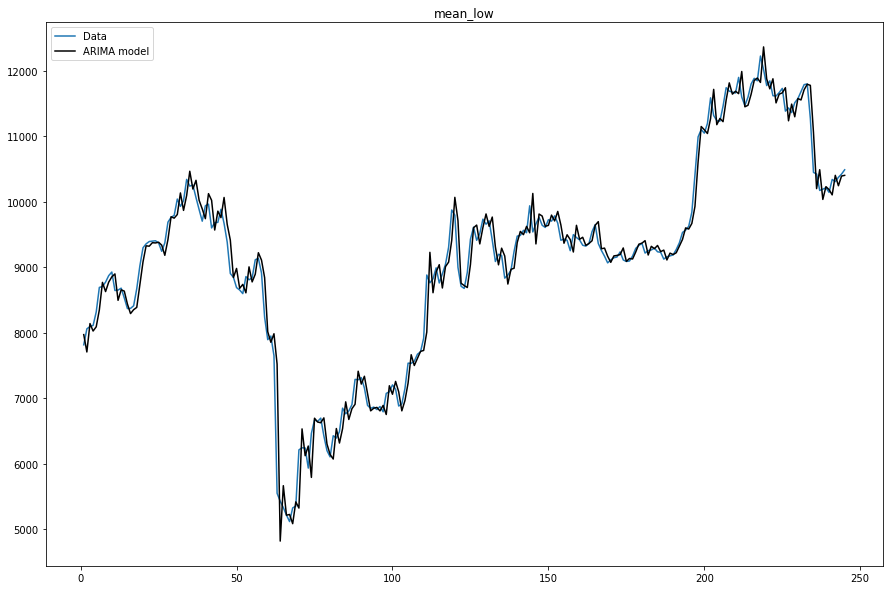

In [ ]:
#ARIMAX model: regression of mean_low
model.plot_fit(figsize=(15,10))

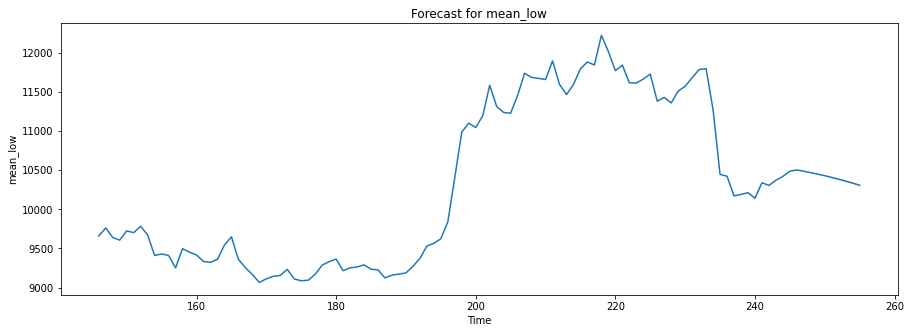

In [ ]:
#ARIMAX model: regression of mean_low
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))

In [ ]:
#ARIMAX model: regression of mean_volume
model = pf.ARIMAX(data=data, formula= 'mean_volume ~ sum_cumulative_cases + mean_cumulative_cases+mean_new_cases+sum_cumulative_cases+sum_cumulative_deaths+mean_cumulative_deaths',
                  ar=1, ma=1, family=pf.Normal)
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: mean_volume                         Method: MLE                                       
Start Date: 1                                           Log Likelihood: -9730.4951                        
End Date: 245                                           AIC: 19478.9901                                   
Number of observations: 245                             BIC: 19510.5015                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0001     0.0069     0.0131   0.9896   (-0.0134 | 0.0136)       
MA(1)                                

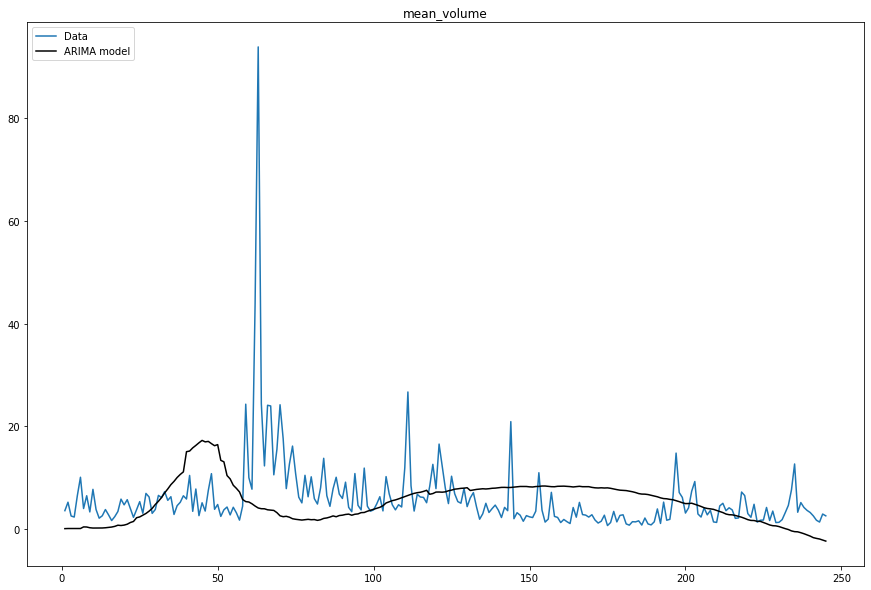

In [ ]:
#ARIMAX model: regression of mean_volume 
model.plot_fit(figsize=(15,10))

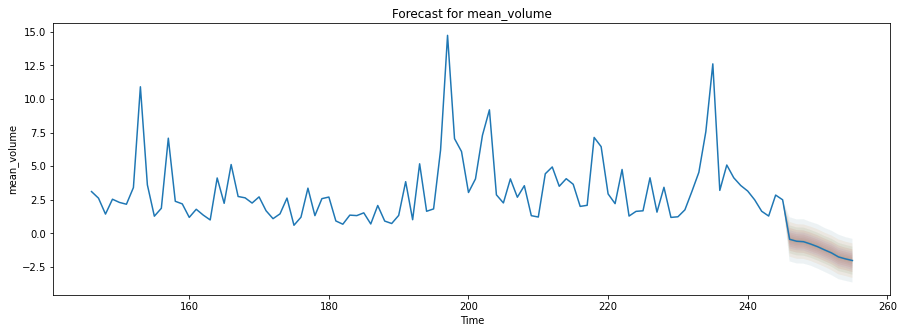

In [ ]:
#ARIMAX model: regression of mean_volume 
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))

#ARIMAX (without Covid-19)

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/PoliNemkova/crypto/5aa17c1d623cff982ecc6f52330c2bfb0c790b7e/bitcoin-covid19.csv')


In [ ]:
#Adding new feature mean_price
data['mean_price']=(data['mean_high']+data['mean_low'])/2

In [ ]:
#removing non sensitive features
data=data.drop(['date','skew_volume','kurt_volume','skew_low','kurt_low','kurt_high', 'skew_high', 'kurt_close',
       'skew_close','kurt_open', 'skew_open','kurt_cumulative_deaths',
       'skew_cumulative_deaths', 'kurt_new_deaths', 'skew_new_deaths',  'kurt_cumulative_cases',
       'skew_cumulative_cases', 'kurt_new_cases', 'skew_new_cases'], axis=1)

In [ ]:
##removing Covid data

data=data.drop(['sum_new_cases','mean_new_cases','sum_cumulative_cases','mean_cumulative_cases','sum_new_deaths','mean_new_deaths','sum_cumulative_deaths', 'mean_cumulative_deaths' ], axis=1)


In [ ]:
data.head()

,sum_open,mean_open,sum_close,mean_close,sum_high,mean_high,sum_low,mean_low,sum_volume,mean_volume,mean_price
0,1.155771e+07,8026.185221,1.155732e+07,8025.913318,1.156170e+07,8028.955982,1.155310e+07,8022.987117,9277.814487,6.442927,8025.971550
1,1.125633e+07,7816.897796,1.125624e+07,7816.835135,1.125929e+07,7818.948853,1.125331e+07,7814.797290,5054.642417,3.510168,7816.873071
2,1.160109e+07,8061.907943,1.160120e+07,8061.987280,1.160525e+07,8064.805258,1.159688e+07,8058.987007,7423.894835,5.159065,8061.896132
3,1.165830e+07,8096.039051,1.165836e+07,8096.081200,1.166053e+07,8097.590995,1.165605e+07,8094.479811,3561.372111,2.473175,8096.035403
4,1.168059e+07,8111.518408,1.168053e+07,8111.475775,1.168213e+07,8112.589977,1.167902e+07,8110.431047,3266.132200,2.268147,8111.510512


In [ ]:
!pip install numdifftools
!pip install pyflux

In [ ]:
import patsy
import seaborn
import scipy
import numdifftools
import matplotlib
import pyflux as pf

In [ ]:
data.shape

(246, 11)

In [ ]:
#ARIMAX model: regression of mean_price 
model = pf.ARIMAX(data=data, formula='mean_price ~ sum_open + mean_open + sum_close + mean_close + sum_high + mean_high + sum_low + mean_low + sum_volume + mean_volume ',
                  ar=1, ma=1, family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(1,0,1)                                                                                      
======================================================= ==================================================
Dependent Variable: mean_price                          Method: MLE                                       
Start Date: 1                                           Log Likelihood: -1154.2894                        
End Date: 245                                           AIC: 2336.5789                                    
Number of observations: 245                             BIC: 2385.5965                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0        0.0003     0.0004   0.9997   (-0.0007 | 0.0007)       
MA(1)                                

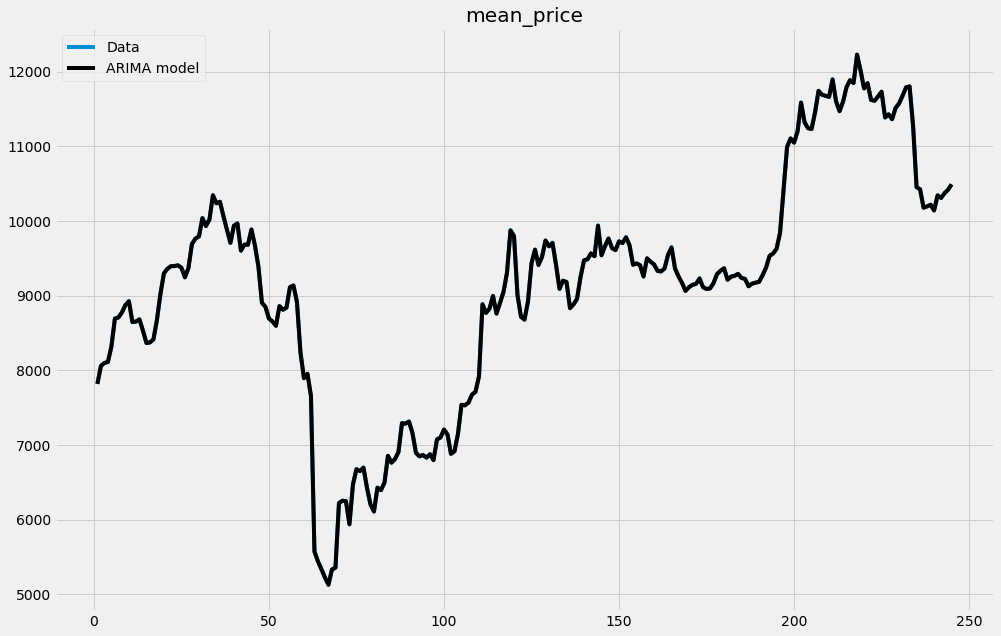

In [ ]:
#ARIMAX model: regression of mean_price
model.plot_fit(figsize=(15,10))

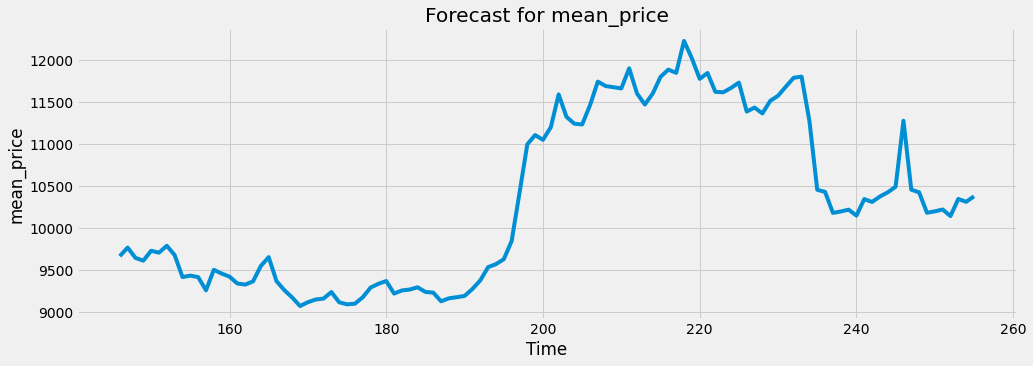

In [ ]:
model.plot_predict(h=10, oos_data=data.iloc[-12:], past_values=100, figsize=(15,5))